In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import json

model_dict = json.load(open("checkpoint.json"))

def parse_success_dict(model_dict: dict):
    """
    model_dict: mapping solver name -> binary string like "100101..." indicating
    which problems that solver solves.
    Returns solver names list and success_matrix of shape (n_solvers, n_problems).
    """
    solvers = list(model_dict.keys())
    # assume all strings are same length and consist of '0'/'1'
    success_matrix = np.array(
        [[int(c) for c in model_dict[name]] for name in solvers],
        dtype=int
    )  # shape: (n_solvers, n_problems)
    return solvers, success_matrix

solvers, success_matrix = parse_success_dict(model_dict['model_dict'])
print(solvers)
print(success_matrix)

['AI-MO_Kimina-Prover-Preview-Distill-7B', 'ByteDance-Seed_BFS-Prover', 'Goedel-LM_Goedel-Prover-SFT', 'deepseek-ai_DeepSeek-Prover-V1', 'deepseek-ai_DeepSeek-Prover-V1.5-RL', 'deepseek-ai_DeepSeek-Prover-V2-7B', 'kfdong_STP_model_Lean', 'stoney0062_Leanabell-Prover-DS-SFT', 'wellecks_llmstep-mathlib4-pythia2.8b']
[[1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1
  0 0 0 0]
 [1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1
  0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0
  0 0 0 0]
 [1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1
  0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
  0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1
  0 0 0 0]
 [0 

In [27]:
from itertools import combinations

def compute_ensemble_metrics(success_matrix: np.ndarray, r: int, conditional: bool = False):
    """
    For each ensemble (subset of r solvers), compute:
      - SSR: fraction of problems solved by exactly one solver in the ensemble.
             If conditional=True, normalize by problems solved by at least one solver.
             Otherwise normalize by all problems.
      - S0: coverage = fraction of problems solved by at least one solver.
    Returns a DataFrame with columns: 'ensemble' (tuple of solver indices), 'SSR', 'S0'.
    """
    n_solvers, n_problems = success_matrix.shape
    ensembles = list(combinations(range(n_solvers), r))

    records = []
    for ens in ensembles:
        sub = success_matrix[np.array(ens), :]  # shape (r, n_problems)
        counts = sub.sum(axis=0)

        # coverage
        s0 = np.mean(counts > 0)

        if conditional:
            solved_mask = counts > 0
            denom = solved_mask.sum()
            if denom > 0:
                ssr = (counts[solved_mask] == 1).sum() / denom
            else:
                ssr = np.nan
        else:
            ssr = np.mean(counts == 1)

        records.append({
            "ensemble": ens,
            "SSR": ssr,
            "S0": s0,
        })
    return pd.DataFrame.from_records(records)

df = compute_ensemble_metrics(success_matrix, 3, conditional=True)

In [28]:
df["SSR"]

,SSR
0,0.333333
1,0.200000
2,0.368421
3,0.300000
4,0.300000
...,...
79,0.714286
80,0.500000
81,0.500000
82,0.666667


In [29]:
df["S0"]

,S0
0,0.600
1,0.500
2,0.475
3,0.500
4,0.500
...,...
79,0.525
80,0.550
81,0.300
82,0.525


In [30]:
def partial_r2(y, X_full, predictors, cov_type="HC3"):
    results = {}
    # Full model
    model_full = sm.OLS(y, sm.add_constant(X_full)).fit(cov_type=cov_type)
    r2_full = model_full.rsquared

    for j, name in enumerate(predictors):
        # Remove predictor j
        mask = [k for k in range(X_full.shape[1]) if k != j]
        X_reduced = X_full[:, mask]
        model_reduced = sm.OLS(y, sm.add_constant(X_reduced)).fit(cov_type=cov_type)
        r2_reduced = model_reduced.rsquared
        r2_partial = (r2_full - r2_reduced) / (1 - r2_reduced)
        results[name] = {
            "R2_full": r2_full,
            "R2_reduced": r2_reduced,
            "partial_R2": r2_partial
        }
    return results

# Fitting using only s0 (

In [31]:
import statsmodels.api as sm

def fit_ssr_on_s0(ssr, s0, robust=True, add_intercept=True):
    """
    Fit SSR ~ S0.
    ssr, s0: 1d arrays of same length.
    """
    X = s0[:, None]
    if add_intercept:
        X = sm.add_constant(X)
    cov_type = "HC3" if robust else "nonrobust"
    model = sm.OLS(ssr, X).fit(cov_type=cov_type)
    return model

model = fit_ssr_on_s0(df["SSR"].to_numpy(), df["S0"].to_numpy())
print(model.summary())  # coefficient on S0, its p-value, R^2, etc.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     30.39
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           3.99e-07
Time:                        18:12:31   Log-Likelihood:                 31.464
No. Observations:                  84   AIC:                            -58.93
Df Residuals:                      82   BIC:                            -54.07
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8275      0.083      9.914      0.0

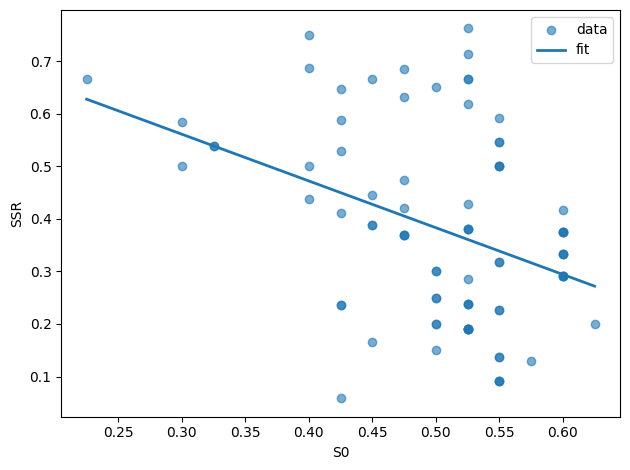

In [32]:
import matplotlib.pyplot as plt

s0 = df["S0"].to_numpy()
ssr = df["SSR"].to_numpy()
pred = model.predict(sm.add_constant(s0))

plt.scatter(s0, ssr, alpha=0.6, label="data")
plt.plot(np.sort(s0), pred[np.argsort(s0)], label="fit", linewidth=2)
plt.xlabel("S0")
plt.ylabel("SSR")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
df["mean_solver_acc"] = [
    success_matrix[list(ens), :].mean() for ens in df["ensemble"]
]

In [34]:
def fit_ssr_model(ssr, edc, s0, robust=True):
    X = np.column_stack([edc, s0])
    Xc = sm.add_constant(X)
    cov_type = "HC3" if robust else "nonrobust"
    model = sm.OLS(ssr, Xc).fit(cov_type=cov_type)
    return model

edc_i_fixed_size = [0.14816353718439737,0.14573178688685098,0.14656327168146768,0.14734911918640137,0.27105091512203217,0.14844022194544473,0.24033634861310324,0.14706761638323465,0.14789910117785135,0.1488547424475352,0.3076301763455073,0.14893513917922974,0.263549084464709,0.1457317272822062,0.14677366614341736,0.2989771415789922,0.14738072951634726,0.2602476229270299,0.14760515093803406,0.2998086263736089,0.14821221431096396,0.2610791077216466,0.2996155818303426,0.14913142720858255,0.26048154135545093,0.30384762585163116,0.3059488733609517,0.26382576922575635,0.14740410447120667,0.14740410447120667,0.14721009135246277,0.308040589094162,0.14766846100489298,0.2629772375027339,0.1465632120768229,0.14645549654960632,0.30071403582890827,0.14744053284327188,0.2610022574663162,0.14645549654960632,0.30071403582890827,0.14744053284327188,0.2610022574663162,0.29937133689721424,0.14721009135246277,0.2592550367116928,0.30398135383923847,0.3067774325609207,0.2629772375027339,0.0005762775739034017,0.0006383558114369711,0.18997053305308023,0.0006126860777537028,0.13689222931861877,0.0006383558114369711,0.18997053305308023,0.0006126860777537028,0.13689222931861877,0.18879762788613638,0.0005520383516947428,0.13531480232874551,0.19239693880081177,0.21791083614031473,0.13802629709243774,0.00014813741048177084,0.18290835618972778,0.0006491343180338541,0.13518162568410239,0.18182174861431122,0.0006747841835021973,0.13369049628575644,0.18594772617022196,0.20971457163492838,0.136928657690684,0.18182174861431122,0.0006747841835021973,0.13369049628575644,0.18594772617022196,0.20971457163492838,0.136928657690684,0.18473839263121286,0.206988458832105,0.13531480232874551,0.21385160088539124]
edc_i_variable_size = [0.3344948784002142,0.3344950667613536,0.3344950643502867,0.3344950716700126,0.33449505666093415,0.33449487018758833,0.334494086962233,0.49692708977867994,0.49715749538435067,0.49576636545103153,0.49604683373032427,0.334152885640466,0.4999991959604131,0.3338499482869377,0.49538887236164797,0.4950040790755435,0.49490338995815125,0.4999993230153705,0.4953275460602639,0.49469948565212424,0.4947236464570661,0.4999993315552104,0.494423631459739,0.49244407277776386,0.49999934273278823,0.49476603809200864,0.4999993296742038,0.49999922018822535,0.49692708635529215,0.49715749286796357,0.4957663612832934,0.4960468294140969,0.3341528946814852,0.4999992949564221,0.33384995088157216,0.49538887330493137,0.4950040798703377,0.494903404110192,0.49999942712240103,0.49532754791054795,0.49469948735391905,0.4947236615161075,0.4999994365692417,0.4944236315101828,0.4924440861854542,0.4999994460954684,0.49476605135120977,0.49999943288839477,0.4999993367596629,0.32793500072633225,0.4880827858966465,0.48797847575042397,0.3259840383737658,0.4969271549312773,0.4882518685190007,0.48790429125074297,0.326034703796419,0.4971575723948556,0.4862372981539617,0.3223639912127207,0.4957664446680374,0.3249664396668474,0.4960469147493349,0.33415305700409054,0.3245666450820863,0.3235538062484314,0.32347747776657343,0.3338499691022821,0.48481686715967953,0.4827368191909045,0.4953888953834933,0.484674006079634,0.4950041038993936,0.4949035051266153,0.48445095075294375,0.48249575270650286,0.4953275809400168,0.48418967247319716,0.49469952233388187,0.4947237734834377,0.4816342356304328,0.49442367034799756,0.4924442020106364,0.4947661691268858]


df["EDC"] = edc_i_variable_size
X = np.column_stack([df["EDC"], df["mean_solver_acc"]])
Xc = sm.add_constant(X)
model = sm.OLS(df["SSR"], Xc).fit(cov_type="HC3")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SSR   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     66.68
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           7.63e-18
Time:                        18:12:31   Log-Likelihood:                 65.581
No. Observations:                  84   AIC:                            -125.2
Df Residuals:                      81   BIC:                            -117.9
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6985      0.092      7.595      0.0

In [35]:
y = df["SSR"].values
X = np.column_stack([df["EDC"], df["mean_solver_acc"]])
predictors = ["EDC", "mean_solver_acc"]

partial_r2_results = partial_r2(y, X, predictors)
for k, v in partial_r2_results.items():
    print(k, v)

EDC {'R2_full': np.float64(0.6209444125885536), 'R2_reduced': np.float64(0.6016252176448329), 'partial_R2': np.float64(0.04849502478421654)}
mean_solver_acc {'R2_full': np.float64(0.6209444125885536), 'R2_reduced': np.float64(0.14560276132511762), 'partial_R2': np.float64(0.5563473636696926)}


In [36]:
from sklearn.linear_model import RidgeCV, LassoCV

def fit_regularized(ssr: np.ndarray, edc: np.ndarray, s0: np.ndarray):
    """
    Fit regularized alternatives (ridge and lasso) to SSR ~ EDC + S0 for comparison.
    """
    X = np.column_stack([edc, s0])
    # no intercept here; these estimators include their own internal handling if needed
    ridge = RidgeCV(alphas=np.logspace(-4, 4, 50), store_cv_values=True).fit(X, ssr)
    lasso = LassoCV(cv=5, max_iter=5000).fit(X, ssr)
    return ridge, lasso


ridge, lasso = fit_regularized(df["SSR"], df["EDC"], df["S0"])
print("Ridge alpha:", ridge.alpha_)
print("Ridge coefs:", ridge.coef_)

print("Lasso alpha:", lasso.alpha_)
print("Lasso coefs:", lasso.coef_)

Ridge alpha: 0.02811768697974228
Ridge coefs: [ 0.81744915 -0.75936834]
Lasso alpha: 0.0005322378954023762
Lasso coefs: [ 0.77137373 -0.71783862]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


# MODEL LOO (Leave-One-Out) Rate

In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
from typing import Iterable, Tuple, Optional
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import resample

# leave-one-out coverage for ensembles of size 3 (conditional: among left-out failures)
def leave_one_out_coverage_for_3(
    success_matrix: np.ndarray,
    ensembles: Optional[Iterable[Tuple[int,int,int]]] = None,
    conditional: bool = True
) -> pd.DataFrame:
    n_solvers, n_problems = success_matrix.shape
    if ensembles is None:
        ensembles = list(combinations(range(n_solvers), 3))
    else:
        ensembles = list(ensembles)

    records = []
    for ens in ensembles:
        i0, i1, i2 = ens
        per_rates = []
        for idx in (i0, i1, i2):
            others = [m for m in ens if m != idx]
            fails = success_matrix[idx, :] == 0
            others_or = np.logical_xor(success_matrix[others[0], :] == 1,
                                      success_matrix[others[1], :] == 1)
            if conditional:
                rate = np.mean(others_or[fails]) if np.any(fails) else np.nan
            else:
                rate = np.mean((fails & others_or).astype(float))
            per_rates.append(rate)
        loo_avg = np.nanmean(per_rates)
        records.append({
            "ensemble": ens,
            "left_out_0_rate": per_rates[0],
            "left_out_1_rate": per_rates[1],
            "left_out_2_rate": per_rates[2],
            "loo_avg": loo_avg,
        })
    return pd.DataFrame.from_records(records)

# OLS Metric (conditional = True)

conditional=True means that we are conditioning over problems where the LOO model fails.

In [38]:
df_loo = leave_one_out_coverage_for_3(success_matrix, conditional=True)

assert all(df["ensemble"] == df_loo["ensemble"]) # Sanity Check

X = np.column_stack([df["EDC"], df["SSR"], df["mean_solver_acc"]])
Xc = sm.add_constant(X)
model = sm.OLS(df_loo["loo_avg"], Xc).fit(cov_type="HC3")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                loo_avg   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     311.9
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           4.91e-44
Time:                        18:12:31   Log-Likelihood:                 209.58
No. Observations:                  84   AIC:                            -411.2
Df Residuals:                      80   BIC:                            -401.4
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2664      0.026    -10.398      0.0

In [39]:
y = df_loo["loo_avg"].values
X = np.column_stack([df["EDC"], df["SSR"], df["mean_solver_acc"]])
predictors = ["EDC","SSR", "mean_solver_acc"]

partial_r2_results = partial_r2(y, X, predictors)
for k, v in partial_r2_results.items():
    print(k, v)

EDC {'R2_full': np.float64(0.898470980266614), 'R2_reduced': np.float64(0.8907378693254215), 'partial_R2': np.float64(0.07077576552322967)}
SSR {'R2_full': np.float64(0.898470980266614), 'R2_reduced': np.float64(0.14082585287797467), 'partial_R2': np.float64(0.8818295219037052)}
mean_solver_acc {'R2_full': np.float64(0.898470980266614), 'R2_reduced': np.float64(0.5870190150457655), 'partial_R2': np.float64(0.7541557034529394)}


In [40]:
X = np.column_stack([df["EDC"], df["S0"]])
Xc = sm.add_constant(X)
model = sm.OLS(df_loo["loo_avg"], Xc).fit(cov_type="HC3")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                loo_avg   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     17.01
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           6.79e-07
Time:                        18:12:31   Log-Likelihood:                 123.95
No. Observations:                  84   AIC:                            -241.9
Df Residuals:                      81   BIC:                            -234.6
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1179      0.050     -2.354      0.0

In [41]:
y = df_loo["loo_avg"].values
X = np.column_stack([df["EDC"], df["S0"]])
predictors = ["EDC", "S0"]

partial_r2_results = partial_r2(y, X, predictors)
for k, v in partial_r2_results.items():
    print(k, v)

EDC {'R2_full': np.float64(0.22004118414181795), 'R2_reduced': np.float64(0.07306716344813835), 'partial_R2': np.float64(0.15855951466819834)}
S0 {'R2_full': np.float64(0.22004118414181795), 'R2_reduced': np.float64(0.12209375914051812), 'partial_R2': np.float64(0.11156934583971974)}


In [42]:
X = np.column_stack([df["EDC"]])
Xc = sm.add_constant(X)
model = sm.OLS(df_loo["loo_avg"], Xc).fit(cov_type="HC3")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                loo_avg   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     13.19
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           0.000488
Time:                        18:12:31   Log-Likelihood:                 118.98
No. Observations:                  84   AIC:                            -234.0
Df Residuals:                      82   BIC:                            -229.1
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0250      0.038      0.654      0.5

# Predicing S0 (coverage)

In [43]:
X = np.column_stack([df["EDC"], df["mean_solver_acc"]])
Xc = sm.add_constant(X)
model_s0 = sm.OLS(df["S0"], Xc).fit(cov_type="HC3")
print(model_s0.summary())

                            OLS Regression Results                            
Dep. Variable:                     S0   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     46.64
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           3.33e-14
Time:                        18:12:31   Log-Likelihood:                 142.00
No. Observations:                  84   AIC:                            -278.0
Df Residuals:                      81   BIC:                            -270.7
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1787      0.040      4.475      0.0

In [44]:
y = df["S0"].values
X = np.column_stack([df["EDC"], df["mean_solver_acc"]])
predictors = ["EDC", "mean_solver_acc"]

partial_r2_results = partial_r2(y, X, predictors)
for k, v in partial_r2_results.items():
    print(k, v)

EDC {'R2_full': np.float64(0.6674413656473248), 'R2_reduced': np.float64(0.6446950596981373), 'partial_R2': np.float64(0.06401910969732787)}
mean_solver_acc {'R2_full': np.float64(0.6674413656473248), 'R2_reduced': np.float64(0.013462468878592815), 'partial_R2': np.float64(0.6629032106111032)}


In [45]:
X = np.column_stack([df["EDC"], df["mean_solver_acc"], df["SSR"]])
Xc = sm.add_constant(X)
model_s0 = sm.OLS(df["S0"], Xc).fit(cov_type="HC3")
print(model_s0.summary())

                            OLS Regression Results                            
Dep. Variable:                     S0   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     44.72
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           4.50e-17
Time:                        18:12:31   Log-Likelihood:                 162.30
No. Observations:                  84   AIC:                            -316.6
Df Residuals:                      80   BIC:                            -306.9
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.052      0.090      0.9

In [46]:
y = df["S0"].values
X = np.column_stack([df["EDC"], df["mean_solver_acc"], df["SSR"]])
predictors = ["EDC", "mean_solver_acc", "SSR"]

partial_r2_results = partial_r2(y, X, predictors)
for k, v in partial_r2_results.items():
    print(k, v)

EDC {'R2_full': np.float64(0.794876271492146), 'R2_reduced': np.float64(0.7901835221240852), 'partial_R2': np.float64(0.022365971517433157)}
mean_solver_acc {'R2_full': np.float64(0.794876271492146), 'R2_reduced': np.float64(0.1469915362184384), 'partial_R2': np.float64(0.7595290818118048)}
SSR {'R2_full': np.float64(0.794876271492146), 'R2_reduced': np.float64(0.6674413656473248), 'partial_R2': np.float64(0.38319530056067563)}


In [47]:
# correlation
print(np.corrcoef(df["S0"], df["mean_solver_acc"])[0,1])

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xc = sm.add_constant(np.column_stack([df["S0"], df["mean_solver_acc"]]))
[vif := variance_inflation_factor(Xc, i) for i in range(Xc.shape[1])]


0.8029290502268166


[np.float64(49.62322492191112),
 np.float64(2.814483804110386),
 np.float64(2.814483804110386)]

In [48]:
# correlation
print(np.corrcoef(df["EDC"], df["SSR"])[0,1])

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xc = sm.add_constant(np.column_stack([df["EDC"], df["SSR"]]))
[vif := variance_inflation_factor(Xc, i) for i in range(Xc.shape[1])]


0.3815792988686857


[np.float64(41.91395357081809),
 np.float64(1.170415767671416),
 np.float64(1.1704157676714155)]

Takeaway: EDC predicts SSR (conditional) stronger than SSR (unconditional). SSR is a strong predictor of coverage even though that's not logically necessary.